# DICOM Multiple Bed Positions

**Special thanks to Dr. Peyman Sheikhzadeh at the Tehran University Of Medical Science for providing this anonymized data**

In [1]:
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform, CutOffTransform
from pytomography.algorithms import OSEM, BSREM
from pytomography.priors import RelativeDifferencePrior
from pytomography.priors import TopNAnatomyNeighbourWeight
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.utils import print_collimator_parameters
import matplotlib.pyplot as plt
import pydicom
import torch

In [2]:
save_path = '/disk1/pytomography_tutorial_data'

## Part 1: Opening Data

This tutorial involves reconstructing Lu-177 SPECT data from multiple bed positions and stitching the resulting reconstructions into a single reconstruction consisting of the full patient.

First we'll specify the projection data file paths: each one corresponds to a different bed position.

In [3]:
files_NM = [
    os.path.join(save_path, 'dicom_multibed_tutorial', 'bed1_projections.dcm'),
    os.path.join(save_path, 'dicom_multibed_tutorial', 'bed2_projections.dcm'),
]
path_CT = os.path.join(save_path, 'dicom_multibed_tutorial', 'CT')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]

In this case, the `index_peak` is 1, the `index_lower` is 3 and the `index_upper` is 2 as confirmed by the `EnergyWindowInformationSequence`

In [4]:
print(pydicom.read_file(files_NM[0]).EnergyWindowInformationSequence)

[(0054, 0013)  Energy Window Range Sequence  1 item(s) ---- 
   (0054, 0014) Energy Window Lower Limit           DS: '101.7'
   (0054, 0015) Energy Window Upper Limit           DS: '124.3'
   ---------
(0054, 0018) Energy Window Name                  SH: 'Lu177_EM'(0054, 0013)  Energy Window Range Sequence  1 item(s) ---- 
   (0054, 0014) Energy Window Lower Limit           DS: '187.2'
   (0054, 0015) Energy Window Upper Limit           DS: '228.8'
   ---------
(0054, 0018) Energy Window Name                  SH: 'Lu177_EM'(0054, 0013)  Energy Window Range Sequence  1 item(s) ---- 
   (0054, 0014) Energy Window Lower Limit           DS: '229.63'
   (0054, 0015) Energy Window Upper Limit           DS: '251.16'
   ---------
(0054, 0018) Energy Window Name                  SH: 'sc4_SC'(0054, 0013)  Energy Window Range Sequence  1 item(s) ---- 
   (0054, 0014) Energy Window Lower Limit           DS: '166.89'
   (0054, 0015) Energy Window Upper Limit           DS: '186.31'
   ---------
(005

Before we reconstruct, lets examine the attenuation maps and corresponding projections to insure the data is properly aligned

* Note the attenuation map for each set of projections is derived from a single set of CT files `files_CT` corresponding to a wholebody field of view. The attenuation map for a specific bed position is obtained via alignment.

(0.0, 128.0, 0.0, 128.0)

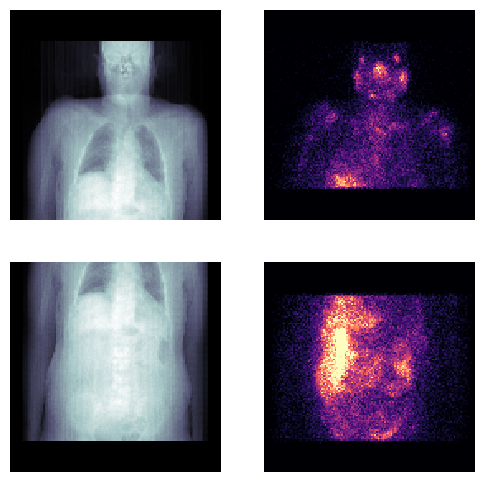

In [5]:
projections1 = dicom.get_projections(files_NM[0])
projections2 = dicom.get_projections(files_NM[1])
attenuation_map1 = dicom.get_attenuation_map_from_CT_slices(files_CT, files_NM[0], index_peak=1)
attenuation_map2 = dicom.get_attenuation_map_from_CT_slices(files_CT, files_NM[1], index_peak=1)
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.pcolormesh(attenuation_map1[0].sum(axis=1).cpu().T, cmap='bone')
plt.axis('off')
plt.subplot(222)
plt.pcolormesh(projections1[0,0].cpu().T, vmax=40, cmap='magma')
plt.axis('off')
plt.subplot(223)
plt.pcolormesh(attenuation_map2[0].sum(axis=1).cpu().T, cmap='bone')
plt.axis('off')
plt.subplot(224)
plt.pcolormesh(projections2[0,0].cpu().T, vmax=40, cmap='magma')
plt.axis('off')

## Part 2: Reconstruction

The following function performs reconstruction of a single bed position (if you are unfamiliar with this, please see the introductory DICOM tutorial). 


In [6]:
def reconstruct_singlebed(file_NM, files_CT):
    object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=1)
    projections = dicom.get_projections(file_NM)
    photopeak = projections[1].unsqueeze(0)
    scatter = scatter = dicom.get_scatter_from_TEW(file_NM, index_peak=1, index_lower=3, index_upper=2)
    # Build system matrix
    attenuation_map = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=1)
    psf_meta = dicom.get_psfmeta_from_scanner_params('GI-MEGP', energy_keV=208)
    att_transform = SPECTAttenuationTransform(attenuation_map)
    psf_transform = SPECTPSFTransform(psf_meta)
    cutoff_transform = CutOffTransform(proj=projections)
    # Create system matrix
    system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [cutoff_transform],
        object_meta = object_meta,
        proj_meta = proj_meta)
    photopeak = cutoff_transform.forward(photopeak)
    scatter = cutoff_transform.forward(scatter)
    likelihood = PoissonLogLikelihood(system_matrix, photopeak, additive_term=scatter)
    reconstruction_algorithm = OSEM(likelihood)
    return reconstruction_algorithm(n_iters=4, n_subsets=8)

From this we can reconstruct each bed position seperately:

In [7]:
recon_upper = reconstruct_singlebed(files_NM[0], files_CT)
recon_lower = reconstruct_singlebed(files_NM[1], files_CT)

We can view each reconstruction seperately

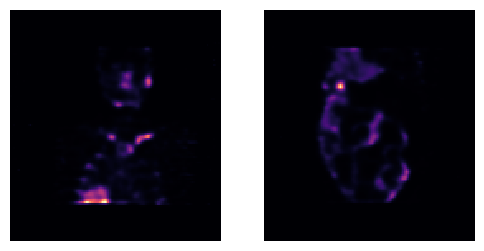

In [8]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.pcolormesh(recon_upper[0,:,64].cpu().T, cmap='magma')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(recon_lower[0,:,64].cpu().T, cmap='magma')
plt.axis('off')
plt.show()

To stitch these reconstructed images together, we use the `dicom.stitch_multibed` function. There are multiple stitching methods to choose from:
* `'TEM'`: Transition error minimization (https://ui.adsabs.harvard.edu/abs/2017SPIE10133E..21C/abstract)
* `'crossfade'`: weighted interpolation (along z) between the two bed positions
* `'average'`: average between the two bed positions in the stitching region
* `'midslice'`: upper bed position above halfway point, lower bed position below halfway point.

In this case, TEM does the best job. 

When using the `stitch_multibed` function. its important that the `files_NM` argument is provided in the same order as the `recons` (i.e. the first recon should correspond to the first `files_NM`)

In [9]:
recon_stitched = dicom.stitch_multibed(
    recons=torch.cat([recon_upper, recon_lower]),
    files_NM = files_NM,
    method='TEM')

Now we can view the stitched image

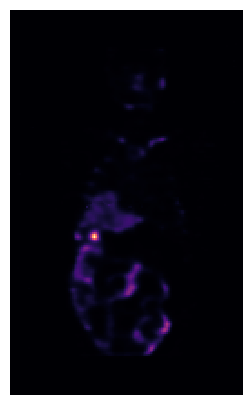

In [10]:
plt.figure(figsize=(3,5))
plt.pcolormesh(recon_stitched[0,:,64].cpu().T, cmap='magma')
plt.axis('off')
plt.show()

When saving the DICOM image, choose the `file_NM` that corresponds to the most superior one

In [11]:
dicom.save_dcm(
    save_path = os.path.join(save_path, 'dicom_multibed_tutorial', 'pytomo_recon'),
    object = recon_stitched,
    file_NM = files_NM[0],
    recon_name = 'OSEM_4it_8ss')

The data can then be imported into any platform one chooses